In [8]:
import torch
import torch.distributions as D
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [707]:
class logistic_regression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(logistic_regression, self).__init__()
        self.w = nn.Linear(input_dim, output_dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(1))
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.register_buffer('prior_mean', torch.zeros(input_dim + 1))
        self.register_buffer('prior_cov', torch.eye(input_dim + 1) + torch.diag(torch.tensor([0., 0., 10])))
    
    def forward(self, x):
        return self.w(x) + self.bias
    
    def forward_w_softmax(self, x):
        return torch.sigmoid(self.forward(x))
    
    def loss(self, x, y):
        # for likelihood, model with Bernoulli
        # prior is N(m, Sigma)
        y_preds = self.forward(x)
        weights = torch.cat([self.w.weight.flatten(), self.bias])
        dw = weights - self.prior_mean
        prior_term = 1/2 * dw @ torch.inverse(self.prior_cov) @ dw.T
        likelihood_term = self.bce_loss(y_preds, y)
        
        return likelihood_term + prior_term, y_preds

In [708]:
torch.diag(torch.tensor([0., 0., 10]))

tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0., 10.]])

In [709]:
# make dataset 
X1 = torch.randn(1000, 2)
X2 = torch.randn(1000, 2) + 2.5
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y = torch.cat([Y1, Y2], dim=0)

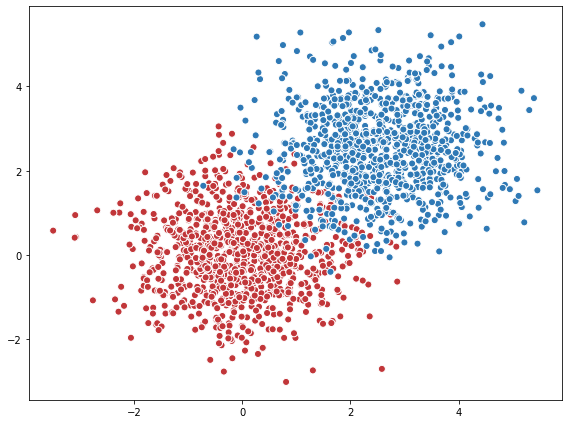

In [710]:
f, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c=Y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
f.tight_layout()

In [711]:
shuffle_idxs = torch.randperm(2000)
X_train, X_test = X[shuffle_idxs][:1600], X[shuffle_idxs][1600:]
Y_train, Y_test = Y[shuffle_idxs][:1600], Y[shuffle_idxs][1600:]


In [712]:
log_reg = logistic_regression(2, 1)
optimiser = torch.optim.Adam(log_reg.parameters(), lr=1e-3)

log_reg.train()
batchsize = 10
for i in range(1, 10000):    
    optimiser.zero_grad()
    loss, y_pred_logits = log_reg.loss(X_train, Y_train)
    if i % 1000 == 0:
        print(f"The loss is: {loss.item():.3f}")
        accuracy = ((torch.sigmoid(y_pred_logits)>=0.5).int() == Y_train).float().mean()
        print(f"The % accuracy is: {accuracy}")
    loss.backward()
    optimiser.step()
    

The loss is: 0.550
The % accuracy is: 0.9049999713897705
The loss is: 0.519
The % accuracy is: 0.9431250095367432
The loss is: 0.519
The % accuracy is: 0.9443749785423279
The loss is: 0.519
The % accuracy is: 0.9443749785423279
The loss is: 0.519
The % accuracy is: 0.9443749785423279
The loss is: 0.519
The % accuracy is: 0.9443749785423279
The loss is: 0.519
The % accuracy is: 0.9443749785423279
The loss is: 0.519
The % accuracy is: 0.9443749785423279
The loss is: 0.519
The % accuracy is: 0.9443749785423279


In [713]:
import numpy as np

In [714]:
xx, yy = np.mgrid[-5:7:.01, -5:7:.01]
grid = np.c_[xx.ravel(), yy.ravel()]

In [715]:
probs = torch.sigmoid(log_reg(torch.from_numpy(grid).float())).reshape(xx.shape).detach().numpy()

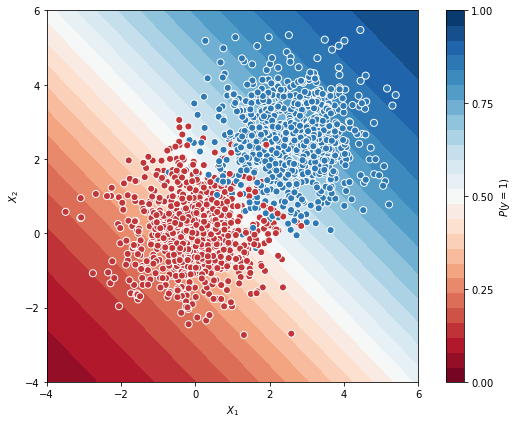

In [716]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-4, 6), ylim=(-4, 6),
       xlabel="$X_1$", ylabel="$X_2$")
f.tight_layout()
f.show()

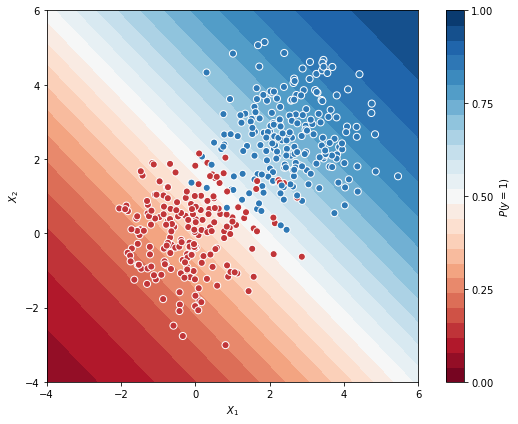

In [717]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-4, 6), ylim=(-4, 6),
       xlabel="$X_1$", ylabel="$X_2$")
f.tight_layout()
f.show()

In [718]:
phi = torch.hstack((X_train, torch.ones(X_train.shape[0], 1)))

In [719]:
phi.shape

torch.Size([1600, 3])

In [720]:
phi_phi_T = torch.einsum("bi, bk -> bik", phi, phi)

In [721]:
prefactor = ((1 - log_reg.forward_w_softmax(X_train))*log_reg.forward_w_softmax(X_train))[:,None].repeat(1, 3, 3) 

In [722]:
hess = (prefactor * phi_phi_T)

In [723]:
hess

tensor([[[ 1.3487,  1.1976,  0.5290],
         [ 1.1976,  1.0634,  0.4697],
         [ 0.5290,  0.4697,  0.2075]],

        [[ 0.0156, -0.0186, -0.0605],
         [-0.0186,  0.0221,  0.0720],
         [-0.0605,  0.0720,  0.2341]],

        [[ 0.9003,  1.2354,  0.4281],
         [ 1.2354,  1.6951,  0.5874],
         [ 0.4281,  0.5874,  0.2036]],

        ...,

        [[ 1.6694,  1.5154,  0.5509],
         [ 1.5154,  1.3757,  0.5001],
         [ 0.5509,  0.5001,  0.1818]],

        [[ 0.9883,  1.5299,  0.4159],
         [ 1.5299,  2.3682,  0.6438],
         [ 0.4159,  0.6438,  0.1750]],

        [[ 1.0853,  0.8422,  0.4981],
         [ 0.8422,  0.6536,  0.3865],
         [ 0.4981,  0.3865,  0.2286]]], grad_fn=<MulBackward0>)

In [724]:
cov = (phi_phi_T * prefactor).sum(0) + torch.inverse(log_reg.prior_cov)

In [740]:
# plot boundary 
# y = (-b - w_1x)/x_2
weights = torch.cat([log_reg.w.weight.flatten(), log_reg.bias])
laplace_approx = D.MultivariateNormal(loc = weights, covariance_matrix=cov)
sampled_weights = laplace_approx.sample()
xs = torch.linspace(-4, 8, 100).numpy()
ys = ((-sampled_weights[-3] - sampled_weights[0]*xs) / sampled_weights[1]).numpy()

In [738]:
xs = torch.linspace(-4, 8, 100).numpy()
ys = ((-log_reg.bias.detach() - log_reg.w.weight[0,0].detach()*xs) / log_reg.w.weight[0,1].detach()).numpy()

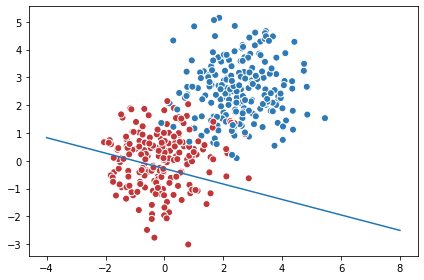

In [741]:
plt.plot(xs, ys)
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
plt.tight_layout()